In [33]:
# some useful mysklearn package import statements and reloads
import importlib
import os
import numpy as np
from tabulate import tabulate
from copy import deepcopy

import mysklearn.myutils
importlib.reload(mysklearn.myutils)
import mysklearn.myutils as myutils

import mypytable
import myutils
importlib.reload(mypytable)
importlib.reload(myutils)
from mypytable import MyPyTable 
import myutils



from sklearn.feature_selection import chi2

import mysklearn.myclassifiers
importlib.reload(mysklearn.myclassifiers)
from mysklearn.myclassifiers import MyKNeighborsClassifier, MyDummyClassifier, MyNaiveBayesClassifier, MyDecisionTreeClassifier, MyRandomForestClassifier

import mysklearn.myevaluation
importlib.reload(mysklearn.myevaluation)
import mysklearn.myevaluation as myevaluation

# Introduction
Team Members: Jackie Ramsey and Lin AI Tan  

Dataset Topic: Mental health status is relation to work/job conditions and personal wellness.  

Description: Each row in our dataset is a survey completed by a person in the work force. This dataset reported the result of attributes that could possibly determine the status of a person's mental health. Most of these attribute topics had to do with a person's relationship with their company or personal state of being. This included attributes such as benefits, remote_work, family_history, and others. The attribute we chose to classify was the mental_health_consequence. The result could be either "yes", "no", or "maybe".  

Findings: We performed and compared the Dummy, kNN, Naive Bayes, Decision Tree, and Random Forest classifiers. The classifier that had the best performance was the ___ classifier.  

In [34]:
survey_fname = os.path.join("input_data","survey.csv")
survey_table = MyPyTable()
survey_table.load_from_file(survey_fname)

# Data Analysis
dataset information:
1. original: 27 attributes with 1259 rows  
2. cleaned: 23 attributes with 1005 rows  
3. attribute selection: 12 attributes with 1005 rows  
4. resulting attributes: 'treatment', 'tech_company', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'mental_vs_physical', 'obs_consequence' + classifer('mental_health_consequence')

summary statistics:  
data visulization

## Clean dataset:  
a) Remove irrelevant columns or columns that we cannot classify:  
- Timestamp : removed because cannot be classify    
- Comments : removed because cannot be classify    
- Country : removed because majority is United States. We are also not interested in places but more interested in exploring mental health of people in tech in general regardless of their physical location  
- State : removed because again, we are interested in exploring mental health of people in tech in general regardless of their physical location
    

In [35]:
name_of_col_to_remove = ["Timestamp","Country","state","comments"]
for col_name in name_of_col_to_remove:
    survey_table.data, survey_table.column_names = myutils.remove_column(survey_table.data,survey_table.column_names,col_name)
print(survey_table.column_names)

['Age', 'Gender', 'self_employed', 'family_history', 'treatment', 'work_interfere', 'no_employees', 'remote_work', 'tech_company', 'benefits', 'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'mental_health_consequence', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'phys_health_interview', 'mental_vs_physical', 'obs_consequence']


b) Ensure consistency of data  
Some columns do not use consistent label. To identify columns with inconsistent label, we will print out all unique labels, and then edit from here:      

In [36]:
for names in survey_table.column_names:
    labels = myutils.get_groups_in_col(survey_table.data,survey_table.column_names,names)
    print()
    print(names)
    print(labels)


Age
[37.0, 44.0, 32.0, 31.0, 33.0, 35.0, 39.0, 42.0, 23.0, 29.0, 36.0, 27.0, 46.0, 41.0, 34.0, 30.0, 40.0, 38.0, 50.0, 24.0, 18.0, 28.0, 26.0, 22.0, 19.0, 25.0, 45.0, 21.0, -29.0, 43.0, 56.0, 60.0, 54.0, 329.0, 55.0, 99999999999.0, 48.0, 20.0, 57.0, 58.0, 47.0, 62.0, 51.0, 65.0, 49.0, -1726.0, 5.0, 53.0, 61.0, 8.0, 11.0, -1.0, 72.0]

Gender
['Female', 'M', 'Male', 'male', 'female', 'm', 'Male-ish', 'maile', 'Trans-female', 'Cis Female', 'F', 'something kinda male?', 'Cis Male', 'Woman', 'f', 'Mal', 'Male (CIS)', 'queer/she/they', 'non-binary', 'Femake', 'woman', 'Make', 'Nah', 'All', 'Enby', 'fluid', 'Genderqueer', 'Female ', 'Androgyne', 'Agender', 'cis-female/femme', 'Guy (-ish) ^_^', 'male leaning androgynous', 'Male ', 'Man', 'Trans woman', 'msle', 'Neuter', 'Female (trans)', 'queer', 'Female (cis)', 'Mail', 'cis male', 'A little about you', 'Malr', 'p', 'femail', 'Cis Man', 'ostensibly male, unsure what that really means']

self_employed
['NA', 'Yes', 'No']

family_history
['No',

- Gender: Male, M, Female, F, m, f, cis-female/femme, cis-male and mispelling such as msle and "A little about you". Other categories such as male-ish, trans, neuter and p are also present but in relatively low amount (2- 3 rows ish in the whole dataset). Because of this, mispellings and other categories rows will be removed because it is ambiguous as to how to classify them as well as the low number of rows having this classification, so it has little impact. Female, female f and cis-female will be converted to F, and Male, male, m and cis-male will be converted to male 

In [37]:
# group up by gender  
gender_labels = myutils.get_groups_in_col(survey_table.data,survey_table.column_names,"Gender")
print(gender_labels)

['Female', 'M', 'Male', 'male', 'female', 'm', 'Male-ish', 'maile', 'Trans-female', 'Cis Female', 'F', 'something kinda male?', 'Cis Male', 'Woman', 'f', 'Mal', 'Male (CIS)', 'queer/she/they', 'non-binary', 'Femake', 'woman', 'Make', 'Nah', 'All', 'Enby', 'fluid', 'Genderqueer', 'Female ', 'Androgyne', 'Agender', 'cis-female/femme', 'Guy (-ish) ^_^', 'male leaning androgynous', 'Male ', 'Man', 'Trans woman', 'msle', 'Neuter', 'Female (trans)', 'queer', 'Female (cis)', 'Mail', 'cis male', 'A little about you', 'Malr', 'p', 'femail', 'Cis Man', 'ostensibly male, unsure what that really means']


In [38]:
#remove any gender label that is not Male, m, M, female, Female, f or Cis Female or Cis Male
gender_col= survey_table.get_column("Gender")
col_index = survey_table.column_names.index("Gender")
survey_table.data = myutils.remove_gender_rows(survey_table.data, gender_col,col_index)
print(len(gender_col)) # only 45 rows removed in total

1214


- self_employed: No, Yes and NA. NA will be discarded because of low ambiguity and also not obvious classification, and also the number of rows present are not alot  
- NA in work_interfere will also be discarded

In [39]:
# group up by self_employed:  
print(len(survey_table.data))
self_employed_labels = myutils.get_groups_in_col(survey_table.data,survey_table.column_names,"self_employed")

# remove NA values
survey_table.data = myutils.remove_NA(survey_table.data,survey_table.column_names,"self_employed")
print(len(survey_table.data)) # only 9 rows removed

1214
1205


In [40]:
# group up by work interfere:  
work_inf_labels = myutils.get_groups_in_col(survey_table.data,survey_table.column_names,"work_interfere")
print(work_inf_labels)

# remove NA values
survey_table.data = myutils.remove_NA(survey_table.data,survey_table.column_names,"work_interfere")
print(len(survey_table.data)) # 200 rows removed


['Often', 'Rarely', 'Never', 'Sometimes', 'NA']
1005


Group by age:  
The following is a popular type of demographic question for age, this one taken from the profile questionnaire for the American Marketing Association itself:

Age Range  
[ ] 21 and Under  
[ ] 22 to 34  
[ ] 35 to 44  
[ ] 45 to 54  
[ ] 55 to 64  
[ ] 65 and Over  

In [41]:
# group age values
survey_table.data = myutils.group_by_age(survey_table.data,survey_table.column_names,"Age")

## Attribute Selection
a) used scikit learn to implement $X^2$

In [42]:
copied_data = deepcopy(survey_table.data)
copied_column_names = deepcopy(survey_table.column_names)
copied_data = myutils.convert_attributes_to_numeric(copied_data,copied_column_names)
# print(survey_table.data)
y_data = myutils.get_column(copied_data,copied_column_names, "mental_health_consequence")
X_data, X_header = myutils.remove_column(copied_data,copied_column_names, "mental_health_consequence")

In [43]:
chi_2, p_value = chi2(X_data, y_data)
myutils.
headers_to_remove = myutils.col_pval(p_value, X_header)
y_data = myutils.get_column(survey_table.data,survey_table.column_names,"mental_health_consequence")

p-values > 0.05
Age 0.8824733457290607
Gender 0.15795134688643178
self_employed 0.6796214001313641
family_history 0.078255208808712
work_interfere 0.08993466307843892
no_employees 0.5793739376203617
remote_work 0.33147416819557657
benefits 0.053843040003000935
care_options 0.6531744396799135
phys_health_interview 0.18637924658189706


In [44]:
# remove headers with p_value larger than 0.05
for header in headers_to_remove:
    survey_table.data, survey_table.column_names = myutils.remove_column(survey_table.data,survey_table.column_names,header)

y_data = myutils.get_column(survey_table.data,survey_table.column_names,"mental_health_consequence")
survey_table.data, survey_table.column_names = myutils.remove_column(survey_table.data,survey_table.column_names, "mental_health_consequence")
print(survey_table.column_names)
print(survey_table.data[0])

['treatment', 'tech_company', 'wellness_program', 'seek_help', 'anonymity', 'leave', 'phys_health_consequence', 'coworkers', 'supervisor', 'mental_health_interview', 'mental_vs_physical', 'obs_consequence']
['Yes', 'Yes', 'No', 'Yes', 'Yes', 'Somewhat easy', 'No', 'Some of them', 'Yes', 'No', 'Yes', 'No']


## Visualization

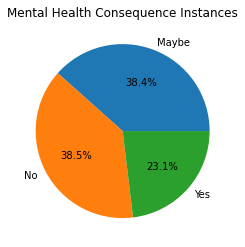

In [45]:
table = [survey_table.data[i] + [y_data[i]] for i in range(len(y_data))]
header_names = survey_table.column_names + ["mental_health_consequence"]
mental_consequence_names, mental_consequence__subtables = myutils.group_by(table, header_names, "mental_health_consequence")
mc_sums = [len(mental_consequence__subtables[0]), len(mental_consequence__subtables[1]), len(mental_consequence__subtables[2])]
myutils.pie_chart(mental_consequence_names, mc_sums, "Mental Health Consequence Instances")


# Classification

In [46]:
n_splits = 10
train_folds, test_folds = myevaluation.stratified_kfold_cross_validation(survey_table.data, y_data, n_splits=n_splits)
labels = ["No","Maybe","Yes"]
pos_label = "Yes"
matrices = []

In [47]:
remainder_set_X, test_set_X, remainder_set_y, test_set_y = myevaluation.train_test_split(
    survey_table.data, y_data)

N_val = [15,30,40]
M_val = [5,10,15]
F_val = [2,5,9]
label_high = ["small","medium","high"]

for i,n_val in enumerate(N_val):
    for j,m_val in enumerate(M_val):
        for k,f_val in enumerate(F_val):
            print(label_high[i],"N val",label_high[j], "M val",label_high[k],"f val")
            random_forest = MyRandomForestClassifier(n_val,m_val,f_val)
            random_forest.fit(remainder_set_X,remainder_set_y)
            y_predicted = random_forest.predict(test_set_X)

            precision = myevaluation.binary_precision_score(test_set_y, y_predicted)
            recall = myevaluation.binary_recall_score(test_set_y, y_predicted)
            f1 = myevaluation.binary_f1_score(test_set_y, y_predicted)

            print("Random Forest Classifier")
            print("Precision:", float("{:.2f}".format(precision)))
            print("Recall:", float("{:.2f}".format(recall)))
            print("F1:", float("{:.2f}".format(f1)))

# labels = ["No", "Maybe", "Yes"]
# matrix = myevaluation.confusion_matrix(test_set_y, y_predicted, labels)
# myutils.confusion_matrix_printing("Random Forest Classifier", matrix)

small N val small M val small f val
Random Forest Classifier
Precision: 0.27
Recall: 0.1
F1: 0.15
small N val small M val medium f val
Random Forest Classifier
Precision: 0.54
Recall: 0.29
F1: 0.37
small N val small M val high f val
Random Forest Classifier
Precision: 0.62
Recall: 0.66
F1: 0.64
small N val medium M val small f val
Random Forest Classifier
Precision: 0.0
Recall: 0.0
F1: 0.0
small N val medium M val medium f val
Random Forest Classifier
Precision: 0.52
Recall: 0.27
F1: 0.35
small N val medium M val high f val
Random Forest Classifier
Precision: 0.76
Recall: 0.55
F1: 0.64
small N val high M val small f val
Random Forest Classifier
Precision: 0.06
Recall: 0.04
F1: 0.05
small N val high M val medium f val
Random Forest Classifier
Precision: 0.32
Recall: 0.24
F1: 0.27
small N val high M val high f val
Random Forest Classifier
Precision: 0.58
Recall: 0.7
F1: 0.63
medium N val small M val small f val
Random Forest Classifier
Precision: 0.22
Recall: 0.13
F1: 0.17
medium N val s

In our iterations of different N values, M values and F values, we found that the higher the f value, the higher the precision, recall and f1 values is regardless of the N value and M values. N values and M values have little effect on the precision, but still a small N value and M value is not as precise as a medium or large N value and M value for the same f value. We also found that larger M values or larger N values independent of F values does not show an increase in precision, and medium is the best balance for M values while for N values smaller is better. Thus, the best combination, that would give us the most gain is to use a small N value, medium M and high F value as it gives us the best precison, recall and f1 score at 0.76

In [48]:
classifier_names= ["Dummy Classifier","KNN Classifier","Naive Bayes Classifier","Decision Tree Classifier"]
f = 10
for name in classifier_names:
    myutils.parameterized_classifiers(train_folds,test_folds,n_splits,survey_table,y_data,name, f)

Dummy Classifier (Stratified 10-Fold Cross Validation Results):
--------------------------------------------------------------
Accuracy: 0.39
Error Rate: 0.61

Precision: 0.39
Recall: 1.0
F1: 0.56

Confusion Matrices

Dummy Classifier (Stratified 10-fold cross validation Results):
Mental Health Consequences      No    Maybe    Yes    Total    Recognition (%)
----------------------------  ----  -------  -----  -------  -----------------
No                             387        0      0      387                100
Maybe                          386        0      0      386                  0
Yes                            232        0      0      232                  0


KeyboardInterrupt: 

## Results
Approach: We used stratified cross fold validation for each of our classifiers (except random forest) so that we could use more than one instance to develop the confusion matrices and see a more accurate representation of the classifier's performance.  

Dummy:  
kNN:  
Naive Bayes:  
Random Forest Classifier: When N, M, and F were larger, the recognition increased. This showed that a greater number of decision trees used caused better precision. However, the recognition leveled out soon after and was consistently around the values shown above.  

Best:  

# Conclusion
ideas to imrpove classification  
challenges performing classifiacation  
brief showing of any key components of code  
brief breakdown of what each partner contributed to the implementation  
sources  